In [84]:
#!/usr/bin/env python
import math
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pickle
from sklearn import datasets, metrics
import urllib
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_svmlight_file

In [85]:
def run_experiment(method_name, 
                   closure, 
                   X, 
                   y, 
                   X_test, 
                   y_test,
                   batch_size=10, 
                   max_epochs=50, 
                   m = 0, 
                   num_restarts=10, 
                   verbose=False, 
                   seed=9513451,
                   **kwargs):
    '''Run an experiment with multiple restarts and compute basic statistics from the runs.'''
    # set the experiment seed
    print("Running Experiment:")
    np.random.seed(seed)
    loss_results = []
    gradnorm_results = []
    line_search_results = []
    arg_dict = kwargs

    n,d = X.shape
    n_test = X_test.shape[0]
    x_sum = np.zeros(d)

    # do the restarts
    for i in range(num_restarts):
        if method_name=="svrg":
            init_step_size = arg_dict["init_step_size"]
            x, loss_record, gradnorm_record = svrg(closure = closure, 
                                                   batch_size = batch_size,
                                                   D = X,
                                                   labels = y,
                                                   init_step_size = init_step_size,
                                                   n = n,
                                                   d = d,
                                                   max_epoch=max_epochs,
                                                   m = m,
                                                   verbose=verbose)
        elif method_name=="svrg_bb":
            init_step_size = arg_dict["init_step_size"]
            x, loss_record, gradnorm_record = svrg_bb(closure = closure, 
                                                   batch_size = batch_size,
                                                   D = X,
                                                   labels = y,
                                                   init_step_size = init_step_size,
                                                   n = n,
                                                   d = d,
                                                   max_epoch=max_epochs,
                                                   m = m,
                                                   verbose=verbose)
        elif method_name=="svrg_armijo":
            c = arg_dict["c"]
            beta = arg_dict["beta"]
            max_iter_armijo = arg_dict["max_iter_armijo"]
            max_step_size = arg_dict["max_step_size"]
            reset_step_size = arg_dict["reset_step_size"]
            x, loss_record, gradnorm_record, line_search_records = svrg_armijo(closure = closure, 
                                                                               batch_size = batch_size,
                                                                               D = X,
                                                                               labels = y,
                                                                               n = n,
                                                                               d = d,
                                                                               c=c,
                                                                               beta=beta,
                                                                               max_iter_armijo=max_iter_armijo,
                                                                               max_step_size=max_step_size,
                                                                               reset_step_size=reset_step_size,
                                                                               max_epoch=max_epochs,
                                                                               m = m,
                                                                               verbose=verbose)
        elif method_name=="svrg_armijo_outer_end":
            c = arg_dict["c"]
            beta = arg_dict["beta"]
            max_iter_armijo = arg_dict["max_iter_armijo"]
            max_step_size = arg_dict["max_step_size"]
            reset_step_size = arg_dict["reset_step_size"]
            x, loss_record, gradnorm_record, line_search_records = svrg_armijo_outer_end(closure = closure, 
                                                                                         batch_size = batch_size,
                                                                                         D = X,
                                                                                         labels = y,
                                                                                         n = n,
                                                                                         d = d,
                                                                                         c=c,
                                                                                         beta=beta,
                                                                                         max_iter_armijo=max_iter_armijo,
                                                                                         max_step_size=max_step_size,
                                                                                         reset_step_size=reset_step_size,
                                                                                         max_epoch=max_epochs,
                                                                                         m = m,
                                                                                         verbose=verbose)
        elif method_name == "svrg_armijo_outer_beginning":
            c = arg_dict["c"]
            beta = arg_dict["beta"]
            max_iter_armijo = arg_dict["max_iter_armijo"]
            max_step_size = arg_dict["max_step_size"]
            reset_step_size = arg_dict["reset_step_size"]
            x, loss_record, gradnorm_record, line_search_records = svrg_armijo_outer_beginning(closure = closure, 
                                                                                               batch_size = batch_size,
                                                                                               D = X,
                                                                                               labels = y,
                                                                                               n = n,
                                                                                               d = d,
                                                                                               c=c,
                                                                                               beta=beta,
                                                                                               max_iter_armijo=max_iter_armijo,
                                                                                               max_step_size=max_step_size,
                                                                                               reset_step_size=reset_step_size,
                                                                                               max_epoch=max_epochs,
                                                                                               m = m,
                                                                                               verbose=verbose)
        elif method_name == "svrg_ada":
            init_step_size = arg_dict["init_step_size"]
            adaptive_termination = arg_dict["adaptive_termination"]            
            x, loss_record, gradnorm_record = svrg_ada(closure = closure, 
                                                   batch_size = batch_size,
                                                   D = X,
                                                   labels = y,
                                                   init_step_size = init_step_size,
                                                   n = n,
                                                   d = d,
                                                   max_epoch=max_epochs,
                                                   m = m,
                                                   verbose=verbose, adaptive_termination = adaptive_termination)   
            
        elif method_name == "svrg_bb_ada":
            init_step_size = arg_dict["init_step_size"]
            x, loss_record, gradnorm_record = svrg_bb_ada(closure = closure, 
                                                   batch_size = batch_size,
                                                   D = X,
                                                   labels = y,
                                                   init_step_size = init_step_size,
                                                   n = n,
                                                   d = d,
                                                   max_epoch=max_epochs,
                                                   m = m,
                                                   verbose=verbose)
            
            
        else:
            print('Method does not exist')
            
        x_sum += x
        loss_results.append(loss_record)
        gradnorm_results.append(gradnorm_record)

        if verbose:
            y_predict = np.sign(np.dot(X_test, x))
            print('Restart %d, Test accuracy: %f' % (i, (np.count_nonzero(y_test == y_predict)*1.0 / n_test)))

    # compute basic statistics from the runs
    x_mean = x_sum / num_restarts

    loss_results = np.stack(loss_results)
    loss_std = loss_results.std(axis=0)
    loss_mean = loss_results.mean(axis=0)

    gradnorm_results = np.stack(gradnorm_results)
    gradnorm_std = gradnorm_results.std(axis=0)
    gradnorm_mean = gradnorm_results.mean(axis=0)

    if method_name in ["svrg_armijo", "svrg_armijo_outer_end", "svrg_armijo_outer_beginning"]:
        line_search_results.append(line_search_records)
        line_search_results = np.stack(line_search_results)
        line_search_std = line_search_results.std(axis=0)
        line_search_mean = line_search_results.mean(axis=0)
        return x_mean, loss_mean, loss_std, gradnorm_mean, gradnorm_std, line_search_mean, line_search_std
    else:                           
        return x_mean, loss_mean, loss_std, gradnorm_mean, gradnorm_std

In [86]:
def make_closure(loss_fn, prior_prec=1e-2):
    '''Computes loss and gradient of the loss w.r.t. w
        Parameters:
            loss_fn: the loss function to use (logistic loss, hinge loss, squared error, etc)
            prior_prec: precision of the Gaussian prior (pass 0 to avoid regularization)
        Returns: a closure fn for computing the loss and gradient. '''

    def closure(w, X, y):
        '''Computes loss and gradient of the loss w.r.t. w
        Parameters:
            w: weight vector
            X: minibatch of input vectors
            y: labels for the input vectors
            prior_prec: precision of the Gaussian prior (pass 0 to avoid regularization)
        Returns: (loss, gradient)'''
        # change the Numpy Arrays into PyTorch Tensors
        X = torch.tensor(X)
        # Type of X is double, so y must be double.
        y = torch.tensor(y, dtype=torch.double)
        w = torch.tensor(w, requires_grad=True)

        # Compute the loss.
        loss = loss_fn(w, X, y) + (prior_prec / 2) * torch.sum(w**2)

        # compute the gradient of loss w.r.t. w.
        loss.backward()
        # Put the gradient and loss back into Numpy.
        grad = w.grad.detach().numpy()
        loss = loss.item()

        return loss, grad

    return closure

# PyTorch Loss Functions

def logistic_loss(w, X, y):
    ''' Logistic Loss'''
    n,d = X.shape
    return torch.mean(torch.log(1 + torch.exp(-torch.mul(y, torch.matmul(X, w)))))

def squared_hinge_loss(w, X, y):
    n,d = X.shape
    '''Squared Hinge Loss '''
    return torch.mean((torch.max( torch.zeros(n,dtype=torch.double) , torch.ones(n,dtype=torch.double) - torch.mul(y, torch.matmul(X, w))))**2 )

def squared_loss(w, X, y):
    n,d = X.shape
    '''Squared Loss'''
    return torch.mean(( y - torch.matmul(X, w) )**2)

In [87]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {"rcv1"       : "rcv1_train.binary.bz2",
                      "mushrooms"  : "mushrooms",
                      "a1a"  : "a1a",
                      "a2a"  : "a2a",
                      "ijcnn"      : "ijcnn1.tr.bz2",
                      "w8a"        : "w8a"}



def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)
        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return [X, y]

def data_load(data_dir, dataset_num, n = 0, d = 0, margin = 1e-6, false_ratio = 0, is_subsample = 0, is_kernelize = 0, test_prop=0.2, split_seed=9513451):

    if dataset_num == 0:
        data_name = 'quantum'

    elif dataset_num == 1:
        data_name = 'rcv1'

    elif dataset_num == 2:
        data_name = 'protein'

    elif dataset_num == 3:
        data_name = 'news'

    elif dataset_num == 4:
        data_name = 'mushrooms'

    elif dataset_num == 5:
        data_name = 'splice'

    elif dataset_num == 6:
        data_name = 'ijcnn'

    elif dataset_num == 7:
        data_name = 'w8a'

    elif dataset_num == 8:
        data_name = 'covtype'

    elif dataset_num == -1:
        data_name = 'synthetic'

    if (dataset_num >= 0):

        # real data
#         data = pickle.load(open(data_dir + data_name +'.pkl', 'rb'), encoding = "latin1")
        data = load_libsvm(data_name, data_dir='./')

        # load real dataset
        A = data[0].toarray()

        if dataset_num < 4:
            y = data[1].toarray().ravel()
        else:
            y = data[1]

    else:

        A, y, w_true = create_dataset(n,d, margin, false_ratio)

        # generate synthetic data - according to the BB paper
#         x = np.random.randn(n, d)
#         w_true = np.random.randn(d)
#         y = np.sign(np.dot(x, w_true))

    # subsample
    if is_subsample == 1:
        A = A[:n,:]
        y = y[:n]

    # split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=test_prop, random_state=split_seed)

    if is_kernelize == 1:
        # Form kernel
        A_train, A_test = kernelize(X_train, X_test, dataset_num, data_dir=data_dir)
    else:
        A_train = X_train
        A_test = X_test

    print('Loaded ', data_name ,' dataset.')

    return A_train, y_train, A_test, y_test

def kernelize(X, X_test, dataset_num, kernel_type=0, data_dir="./Data"):

    n = X.shape[0]

    fname = data_dir + '/Kernel_' + str(n) + '_' + str(dataset_num) + '.p'

    if os.path.isfile(fname):

        print('Reading file ', fname)
        X_kernel, X_test_kernel = pickle.load( open( fname, "rb" ) )

    else:
        if kernel_type == 0:
            X_kernel = RBF_kernel(X, X)
            X_test_kernel = RBF_kernel(X_test, X)
            print('Formed the kernel matrix')

        pickle.dump( (X_kernel, X_test_kernel) , open( fname, "wb" ) )

    return X_kernel, X_test_kernel

def RBF_kernel( A, B, sigma = 1.0 ):

    distance_2 = np.square(  metrics.pairwise.pairwise_distances( X = A, Y = B, metric='euclidean'  )   )
    K = np.exp( -1 * np.divide( distance_2, (2 * (sigma**2)) )  )

    return K


def create_dataset(n,d,gamma = 0, false_ratio = 0):
# create synthetic dataset using the python utility
# X, y = datasets.make_classification(n_samples=n, n_features=d,n_informative = d, n_redundant = 0, class_sep = 2.0 )
# convert into -1/+1
# y = 2 * y - 1

# create linearly separable dataset with margin gamma
#w_star = np.random.random((d,1))
    w_star = np.random.normal(0,1,(d,1))
# normalize w_star
    w_star = w_star / np.linalg.norm(w_star)

    num_positive = 0
    num_negative = 0
    count = 0

    X = np.zeros((n,d))
    y = np.zeros((n))

    while(1):

        x = np.random.normal( 1,1,(1,d) ) 
        # normalize x s.t. || x ||_2 = 1
#         x = x / np.linalg.norm(x)

        temp = np.dot( x, w_star )
        margin = abs( temp )
        sig = np.sign( temp )

        if margin > gamma * np.linalg.norm(w_star):

            if count % 2 == 0:

                # generate positive
                if sig > 0:
                    X[count, :] = x
                else:
                    X[count, :] = -x
                y[ count ] = + 1

            else:

                # generate negative
                if sig < 0:
                    X[count, :] = x
                else:
                    X[count,:] = -x
                y[ count ] = - 1

            count = count + 1

        if count == n:
            break
            
    flip_ind = np.random.choice(n, int(n*false_ratio))
    y[flip_ind] = -y[flip_ind]
    
    return X, y, w_star


In [88]:
def make_minibatches(n, m, minibatch_size):
    ''' Create m minibatches from the training set by sampling without replacement.
        This function may sample the training set multiple times.
    Parameters:
        n: the number of examples in the dataset
        m: number of minibatches to generate
        batch_size: size of the desired minibatches'''

    k = math.ceil(m * minibatch_size / n)
    batches = []
    for i in range(k):
        batches += minibatch_data(n, minibatch_size)

    return batches


def minibatch_data(n, batch_size):
    '''Splits training set into minibatches by sampling **without** replacement.
    This isn't performant for large datasets (e.g. we should switch to PyTorch's streaming data loader eventually).
    Parameters:
        n: the number of examples in the dataset
        batch_size: size of the desired minibatches'''
    # shuffle training set indices before forming minibatches
    indices = np.arange(n)
    np.random.shuffle(indices)

    batches = []
    num_batches = math.floor(n / batch_size)
    # split the training set into minibatches
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        stop_index = (batch_num + 1) * batch_size

        # create a minibatch
        batches.append(indices[start_index:stop_index])

    # generate a final, smaller batch if the batch_size doesn't divide evenly into n
    if num_batches != math.ceil(n / batch_size):
        batches.append(indices[stop_index:])

    return batches

def reset(model):
    # reset the model
    for param in model.parameters():
        param.data = torch.zeros_like(param)
    loss_results = []
    gradnorm_results = []

    return model

In [89]:
def plotting(results, labels, max_epochs):
    plt.figure()

    offset = 0
    colors = ['r', 'b', 'g','k','cyan','lightgreen']

    x = range(max_epochs)

    for i in range(len(labels)):
        plt.plot( x, ( results[i,:] ), color = colors[i], label = labels[i] )

    plt.xlabel('Number of Effective Passes')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

def plot_shaded_error_bars(results_mean, results_std, max_epochs, ylabel="Loss", colors=None, labels=None):
    fig = plt.figure()
    offset = 0
    if colors is None:
        colors = ['r', 'b', 'g','k','cyan','lightgreen']
    if labels is None:
        labels = ['SVRG-BB', 'SVRG']

    x = range(max_epochs)

    for i in range(results_mean.shape[0]):
        plt.plot( x, ( results_mean[i,:] ), color = colors[i], label = labels[i] )
        plt.fill_between(x, (results_mean[i,:] - results_std[i,:]), (results_mean[i,:] + results_std[i,:]), color=colors[i], alpha=0.5)

    plt.xlabel('Number of Effective Passes')
    plt.ylabel(ylabel)
    plt.legend(loc='best')

    return fig

In [90]:
def svrg_bb(closure, batch_size, D, labels, init_step_size, n, d, max_epoch=100, m=0, x0=None, verbose=True):
    """
        SVRG with Barzilai-Borwein step size for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: initial step size
        n, d: size of the problem
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    step_size = init_step_size

    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()
        # estimate step size by BB method
        if k > 0:
            s = x_tilde - last_x_tilde
            y = full_grad - last_full_grad
            step_size = np.linalg.norm(s)**2 / np.dot(s, y) / m

        last_full_grad = full_grad
        last_x_tilde = x_tilde

        if verbose:
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e' % \
                     (k, step_size, np.linalg.norm(full_grad))
            output += ', Func. value: %e' % loss
            print(output)

        # Add termination condition based on the norm of full gradient
        # Without this, "np.dot(s, y)" can underflow and produce divide-by-zero errors.
        if np.linalg.norm(full_grad) <= 1e-14:
            return x, LOSS, GRAD_NORM

        LOSS[k] = loss
        GRAD_NORM[k] = np.linalg.norm(full_grad)

        # Create Minibatches:
        minibatches = make_minibatches(n, m, batch_size)
        for i in range(m):
            # get the minibatch for this iteration
            indices = minibatches[i]
            Di, labels_i = D[indices, :], labels[indices]

            # compute the gradients:
            x_grad = closure(x, Di, labels_i)[1]
            x_tilde_grad = closure(x_tilde, Di, labels_i)[1]

            x -= step_size * (x_grad - x_tilde_grad + full_grad)

    return x, LOSS, GRAD_NORM


In [91]:
def svrg(closure, batch_size, D, labels, init_step_size, n, d, max_epoch=100, m=0, x0=None, verbose=True):
    """
        SVRG with fixed step size for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: step-size to use
        n, d: size of the problem
    """
    step_size = init_step_size
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))
    
    
    num_grad_evals = 0

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()

        last_full_grad = full_grad
        last_x_tilde = x_tilde

        if verbose:
            output = 'Epoch.: %d, Grad. norm: %.2e' % \
                     (k, np.linalg.norm(full_grad))
            output += ', Func. value: %e' % loss
            output += ', Num gradient evaluations: %d' % num_grad_evals
            print(output)

        if np.linalg.norm(full_grad) <= 1e-14:
            return x, LOSS, GRAD_NORM

        LOSS[k] = loss
        GRAD_NORM[k] = np.linalg.norm(full_grad)
        
        
        num_grad_evals = num_grad_evals + n

        # Create Minibatches:
        minibatches = make_minibatches(n, m, batch_size)
        for i in range(m):
            # get the minibatch for this iteration
            indices = minibatches[i]
            Di, labels_i = D[indices, :], labels[indices]

            # compute the gradients:
            x_grad = closure(x, Di, labels_i)[1]
            x_tilde_grad = closure(x_tilde, Di, labels_i)[1]

            x -= step_size * (x_grad - x_tilde_grad + full_grad)
            
            num_grad_evals = num_grad_evals + 1

    return x, LOSS, GRAD_NORM


In [92]:
def svrg_armijo(closure, 
                batch_size, 
                D, 
                labels,
                n, 
                d,
                c,
                beta,
                max_iter_armijo,
                max_step_size,
                reset_step_size=False,
                max_epoch=100, 
                m=0, 
                x0=None, 
                verbose=True):
    """
        SVRG with Armijo step size in the inner loop for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: initial step size
        n, d: size of the problem
        max_iter_armijo: maximum number of Armijo iterations before falling back to small determined stepsize
        reset_step_size: whether or not the stepsize should be reset to max_step_size at the next iteration
        beta: multiplicative factor in Armijo line search (0 < beta < 1).
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))
    AVERAGE_ARMIJO_STEPS = np.zeros((max_epoch))
    MAX_ARMIJO_STEPS_REACHED = np.zeros((max_epoch))

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()

        last_full_grad = full_grad
        last_x_tilde = x_tilde
        
        start_step_size = max_step_size

        if verbose:
            output = 'Epoch.: %d, Grad. norm: %.2e' % \
                     (k, np.linalg.norm(full_grad))
            output += ', Func. value: %e' % loss
            print(output)

        # Add termination condition based on the norm of full gradient
        # Without this, "np.dot(s, y)" can underflow and produce divide-by-zero errors.
        if np.linalg.norm(full_grad) <= 1e-14:
            return x, LOSS, GRAD_NORM

        LOSS[k] = loss
        GRAD_NORM[k] = np.linalg.norm(full_grad)

        # Create Minibatches:
        minibatches = make_minibatches(n, m, batch_size)
        for i in range(m):
            # get the minibatch for this iteration
            indices = minibatches[i]
            Di, labels_i = D[indices, :], labels[indices]

            # compute the gradients:
            f_x ,x_grad = closure(x, Di, labels_i)
            x_tilde_grad = closure(x_tilde, Di, labels_i)[1]
            g = x_grad - x_tilde_grad + full_grad
            g_norm = np.linalg.norm(g)
            
            step_size = start_step_size
            found = False
            for j in range(max_iter_armijo):
                if closure(x - step_size*g, Di, labels_i)[0] > f_x - c*step_size*g_norm:
                    step_size *= beta
                    AVERAGE_ARMIJO_STEPS[k] += 1
                else:
                    found = True
                    break
            
            if found:
                x -= step_size * g
                if not reset_step_size:
                    start_step_size = step_size
            else:
                MAX_ARMIJO_STEPS_REACHED[k]+=1
                x -= 1e-6*g
        AVERAGE_ARMIJO_STEPS[k] /= m
        if verbose:
            output = 'Epoch.: %d, Avg armijo steps: %.2e, Nb max iteration reached: %.2e' % \
                     (k, AVERAGE_ARMIJO_STEPS[k], MAX_ARMIJO_STEPS_REACHED[k])
            print(output)

    return x, LOSS, GRAD_NORM, AVERAGE_ARMIJO_STEPS

In [93]:
def svrg_armijo_outer_end(closure, 
                batch_size, 
                D, 
                labels,
                n, 
                d,
                c,
                beta,
                max_iter_armijo,
                max_step_size,
                reset_step_size=False,
                max_epoch=100, 
                m=0, 
                x0=None,
                verbose=True):
    """
        SVRG with Armijo step size at the end of the outer loop for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: initial step size
        n, d: size of the problem
        max_iter_armijo: maximum number of Armijo iterations before falling back to small determined stepsize
        reset_step_size: whether or not the stepsize should be reset to max_step_size at the next iteration
        beta: multiplicative factor in Armijo line search (0 < beta < 1).
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    
    start_step_size = max_step_size
    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))
    NB_ARMIJO_STEPS = np.zeros((max_epoch))

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()
        
        last_full_grad = full_grad
        last_x_tilde = x_tilde
        norm_full_grad = np.linalg.norm(full_grad)

        if verbose:
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e' % \
                    (k, start_step_size, norm_full_grad)
            output += ', Func. value: %e' % loss
            print(output)
        
        LOSS[k] = loss
        GRAD_NORM[k] = norm_full_grad
        step_size = start_step_size
        
        found = False
        for j in range(max_iter_armijo):
            # Create Minibatches:
            minibatches = make_minibatches(n, m, batch_size)
            for i in range(m):
                # get the minibatch for this iteration
                indices = minibatches[i]
                Di, labels_i = D[indices, :], labels[indices]

                # compute the gradients:
                f_x ,x_grad = closure(x, Di, labels_i)
                x_tilde_grad = closure(x_tilde, Di, labels_i)[1]
                g = x_grad - x_tilde_grad + full_grad
                x -= step_size * g
                
            if closure(x, D, labels)[0] > loss - c*step_size*norm_full_grad:
                step_size = beta*step_size
                x = x_tilde.copy()
                NB_ARMIJO_STEPS[k]+=1
            else:
                found = True
                break
        if found:
            if not reset_step_size:
                start_step_size = step_size
        if not found:
            x -= 1e-6*full_grad
        
        if verbose:
            output = 'Epoch.: %d, Nb of Armijo steps: %.2e' % \
                         (k, NB_ARMIJO_STEPS[k])
            print(output)

    return x, LOSS, GRAD_NORM, NB_ARMIJO_STEPS

In [94]:
def svrg_armijo_outer_beginning(closure, 
                batch_size, 
                D, 
                labels,
                n, 
                d,
                c,
                beta,
                max_iter_armijo,
                max_step_size,
                reset_step_size=False,
                max_epoch=100, 
                m=0, 
                x0=None,
                verbose=True):
    """
        SVRG with Armijo step size at the beginning of the outer loop for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: initial step size
        n, d: size of the problem
        max_iter_armijo: maximum number of Armijo iterations before falling back to small determined stepsize
        reset_step_size: whether or not the stepsize should be reset to max_step_size at the next iteration
        beta: multiplicative factor in Armijo line search (0 < beta < 1).
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    
    start_step_size = max_step_size
    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))
    NB_ARMIJO_STEPS = np.zeros((max_epoch))

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()
        
        last_full_grad = full_grad
        last_x_tilde = x_tilde
        norm_full_grad = np.linalg.norm(full_grad)
        
        step_size = start_step_size
        while closure(x - step_size*full_grad, D, labels)[0] > loss - c*step_size*norm_full_grad:
            step_size *=beta
            NB_ARMIJO_STEPS[k] +=1
            if NB_ARMIJO_STEPS[k] == max_iter_armijo:
                step_size = 1e-7
                break
        if not reset_step_size:
            start_step_size = step_size

        if verbose:
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e, Nb of Armijo steps: %d' % \
                    (k, step_size, norm_full_grad, NB_ARMIJO_STEPS[k])
            output += ', Func. value: %e' % loss
            print(output)
        
        LOSS[k] = loss
        GRAD_NORM[k] = norm_full_grad  
        
        minibatches = make_minibatches(n, m, batch_size)
        for i in range(m):
            # get the minibatch for this iteration
            indices = minibatches[i]
            Di, labels_i = D[indices, :], labels[indices]

            # compute the gradients:
            x_grad = closure(x, Di, labels_i)[1]
            x_tilde_grad = closure(x_tilde, Di, labels_i)[1]

            x -= step_size * (x_grad - x_tilde_grad + full_grad)

    return x, LOSS, GRAD_NORM, NB_ARMIJO_STEPS

In [95]:
def svrg_ada(closure, batch_size, D, labels, init_step_size, n, d, max_epoch=100, m=0, x0=None, verbose=True, adaptive_termination = False):
    """
        SVRG with fixed step size for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: step-size to use
        n, d: size of the problem
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))
    
    num_grad_evals = 0

    for k in range(max_epoch):
        
#         if k == 0:
        
#             Gk2 = 0
#             step_size = init_step_size
                        
#             minibatches = make_minibatches(n, m, batch_size)
#             for i in range(m):
#                 # get the minibatch for this iteration
#                 indices = minibatches[i]
#                 Di, labels_i = D[indices, :], labels[indices]

#                 # compute the gradients:
#                 x_grad = closure(x, Di, labels_i)[1]

#                 gk = x_grad 

#                 Gk2 = Gk2 + (np.linalg.norm(gk) ** 2)

#                 x -= (step_size / np.sqrt(Gk2)) * (gk)

#                 num_grad_evals =  num_grad_evals  + 1

#                 if adaptive_termination == True:

#                     if i == 0:
#                         org = (step_size / np.sqrt(Gk2))

#                     else:
#                         temp = (step_size / np.sqrt(Gk2))

#                         # check condition to terminate inner loop
#                         if temp/org < 1e-2:
#                             print('Breaking from inner loop')                    
#                             break                            
        
        if k >= 0:
            print('Here')
            loss, full_grad = closure(x, D, labels)
            x_tilde = x.copy()

            last_full_grad = full_grad
            last_x_tilde = x_tilde

            # initialize running sum of gradient norms
            Gk2 = 0
            step_size = init_step_size

            if verbose:
                output = 'Epoch.: %d, Grad. norm: %.2e' % \
                         (k, np.linalg.norm(full_grad))
                output += ', Func. value: %e' % loss
                output += ', Num gradient evaluations: %d' % num_grad_evals            
                print(output)

            if np.linalg.norm(full_grad) <= 1e-14:
                return x, LOSS, GRAD_NORM

            LOSS[k] = loss
            GRAD_NORM[k] = np.linalg.norm(full_grad)

            num_grad_evals =  num_grad_evals  + n

            # Create Minibatches:
            minibatches = make_minibatches(n, m, batch_size)
            for i in range(m):
                # get the minibatch for this iteration
                indices = minibatches[i]
                Di, labels_i = D[indices, :], labels[indices]

                # compute the gradients:
                x_grad = closure(x, Di, labels_i)[1]
                x_tilde_grad = closure(x_tilde, Di, labels_i)[1]

                gk = x_grad - x_tilde_grad + full_grad

                Gk2 = Gk2 + (np.linalg.norm(gk) ** 2)
#                 Gk2 = Gk2 + (np.linalg.norm(x_grad) ** 2)

                x -= (step_size / np.sqrt(Gk2)) * (gk)

                num_grad_evals =  num_grad_evals  + 1

                if adaptive_termination == True:

                    if i == 0:
                        org = (step_size / np.sqrt(Gk2))

                    else:
                        temp = (step_size / np.sqrt(Gk2))

                        # check condition to terminate inner loop
                        if temp/org < 1e-2 and i >=  int(n / batch_size):
                            print(temp/org)
                            print('Breaking from inner loop')                                
                            break
            
            
    return x, LOSS, GRAD_NORM

In [96]:
def svrg_bb_ada(closure, batch_size, D, labels, init_step_size, n, d, max_epoch=100, m=0, x0=None, verbose=True):
    """
        SVRG with Barzilai-Borwein step size for solving finite-sum problems
        Closure: a PyTorch-style closure returning the objective value and it's gradient.
        batch_size: the size of minibatches to use.
        D: the set of input vectors (usually X).
        labels: the labels corresponding to the inputs D.
        init_step_size: initial step size
        n, d: size of the problem
    """
    if not isinstance(m, int) or m <= 0:
        m = n
        if verbose:
            print('Info: set m=n by default')

    if x0 is None:
        x = np.zeros(d)
    elif isinstance(x0, np.ndarray) and x0.shape == (d, ):
        x = x0.copy()
    else:
        raise ValueError('x0 must be a numpy array of size (d, )')

    step_size = init_step_size

    LOSS = np.zeros((max_epoch))
    GRAD_NORM = np.zeros((max_epoch))

    for k in range(max_epoch):
        loss, full_grad = closure(x, D, labels)
        x_tilde = x.copy()
        # estimate step size by BB method
        if k > 0:
            s = x_tilde - last_x_tilde
            y = full_grad - last_full_grad
            step_size = np.linalg.norm(s)**2 / np.dot(s, y) / m

        last_full_grad = full_grad
        last_x_tilde = x_tilde
        
        Gk2 = 0

        if verbose:
            output = 'Epoch.: %d, Step size: %.2e, Grad. norm: %.2e' % \
                     (k, step_size, np.linalg.norm(full_grad))
            output += ', Func. value: %e' % loss
            print(output)

        # Add termination condition based on the norm of full gradient
        # Without this, "np.dot(s, y)" can underflow and produce divide-by-zero errors.
        if np.linalg.norm(full_grad) <= 1e-14:
            return x, LOSS, GRAD_NORM

        LOSS[k] = loss
        GRAD_NORM[k] = np.linalg.norm(full_grad)

        # Create Minibatches:
        minibatches = make_minibatches(n, m, batch_size)
        for i in range(m):
            # get the minibatch for this iteration
            indices = minibatches[i]
            Di, labels_i = D[indices, :], labels[indices]

            # compute the gradients:
            x_grad = closure(x, Di, labels_i)[1]
            x_tilde_grad = closure(x_tilde, Di, labels_i)[1]

            gk = x_grad - x_tilde_grad + full_grad
            
            Gk2 = Gk2 + (np.linalg.norm(gk) ** 2)
                        
            x -= (step_size / np.sqrt(Gk2)) * (gk)

    return x, LOSS, GRAD_NORM


In [97]:
# dataset options
dataset_num = -1
data_dir = './'

is_subsample = 0
is_kernelize = 0
subsampled_n = -1

# set the seed for reproducibility
np.random.seed(6162647)

In [98]:
# optimization options
max_epochs = 15
num_restarts = 1
batch_size = 10
verbose = False

In [99]:
# problem size when generating synthetic data
if dataset_num == -1:
    n, d = 10000, 20
    false_ratio = 0.25
    margin = 1e-6
    print(is_kernelize)
    A, y, A_test, y_test = data_load(data_dir, dataset_num,n, d, margin, false_ratio)
else:
    if is_subsample == 1:
        n = subsampled_n
    else:
        n = 0
    if is_kernelize == 1:
        d = n
    else:
        d = 0
        
    A, y, A_test, y_test = data_load(data_dir, dataset_num, n,d, false_ratio, is_subsample, is_kernelize)
    
    if n == 0:
        n = A.shape[0]
    
    
#define the regularized losses we will use
logistic_closure_l2 = make_closure(logistic_loss, 1/n)
squared_hinge_closure_l2 = make_closure(squared_hinge_loss, 1/n)
squared_closure_l2 = make_closure(squared_loss, 1/n)

0
Loaded  synthetic  dataset.


In [100]:
# choose experiment
exp_num = 7

In [101]:
if exp_num == 0:
    print('Testing SVRG-BB:')
    init_eta = 1e-3
    
    num_variants = 1
    
    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))
    
    x_mean, results_mean[0, :], results_std[0, :], results2_mean[0, :], results2_std[0, :] = run_experiment(svrg_bb, logistic_closure_no_l2, A, y, A_test, y_test, init_eta, batch_size, max_epochs, num_restarts, verbose=verbose)

In [102]:
if exp_num == 1:
    print('Testing robustness to step-size for SVRG:')    
    count = 0
    labels = []
    step_sizes = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    colors = ['r', 'b', 'g','k','cyan','lightgreen','gray']

    num_variants = len(step_sizes)

    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))

    for init_eta in step_sizes: 
        print('Begin to run SVRG with step-size = :', init_eta)
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = 'svrg', closure = logistic_closure_l2, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m =0, num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append(str(init_eta))
    

In [103]:
if exp_num == 2:
    print('Testing robustness to size of inner loop for SVRG:')   

    count = 0
    labels = []
    init_eta = 1e-2
    inner_loop_list = [0.5 , 1, 2, 5, 10]

    colors = ['r', 'b', 'g','k','cyan','lightgreen','gray']

    num_variants = len(inner_loop_list)


    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))

    for inner_loop in inner_loop_list: 
        print('Begin to run SVRG with inner loop size = :', inner_loop)

        m = int(inner_loop * n)

        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg", closure = logistic_closure_l2, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m = m, num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append(str(inner_loop))

In [104]:
if exp_num == 3:
    
    labels = []
    colors = ['r', 'b', 'g','k','cyan','lightgreen','gray']

    step_sizes = [1e-4, 1e-2, 1, 100]
        
    num_variants = len(step_sizes)

    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))     
        
    for init_eta in step_sizes:     
  
        print('Testing SVRG-Ada with step-size:', init_eta)
    
        x_mean, results_mean[0, :], results_std[0, :], results2_mean[0, :], results2_std[0, :] =\
        run_experiment(method_name = "svrg_ada", closure = squared_closure_l2, \
                           X = A, y = y, X_test = A_test, y_test = y_test, \
                           init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                           m = 0, num_restarts = num_restarts, verbose=verbose) 
    
        labels.append(['SVRG-Ada-', str(init_eta)])


In [105]:
if exp_num == 4:
    print('Testing SVRG vs SVRG-Ada vs SVRG-BB wrt step-size robustness:')

    count = 0
    labels = []
    step_sizes = [1e-3, 1e-2, 1e-1]
    colors = ['r', 'b', 'g','r','b','g','r', 'b', 'g']

    num_variants = 3 * len(step_sizes)

    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))
    
    closure = squared_closure_l2

    for init_eta in step_sizes: 
        print('Begin to run SVRG with step-size = :', init_eta)

#         # SVRG
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg", closure = closure, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m = 5 * int(n / batch_size), num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append(str(init_eta))
        
        
        # SVRG BB
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg_bb", closure = closure, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m =5 * int(n / batch_size), num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append('BB' + str(init_eta))
        

        # Ada SVRG
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg_ada", closure = closure, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m = 5 * int(n / batch_size), num_restarts = num_restarts, verbose=verbose,  adaptive_termination = True)
        count = count + 1
        labels.append('Ada' + str(init_eta))
    

In [106]:
if exp_num == 5:
    print('Testing SVRG-BB vs SVRG-BB-Ada wrt step-size robustness:')

    count = 0
    labels = []
    step_sizes = [1e-2, 1e-1, 1]
    colors = ['r', 'b', 'g','k','cyan','lightgreen','gray']

    num_variants = 2 * len(step_sizes)

    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))
    
    closure = logistic_closure_l2

    for init_eta in step_sizes: 
        print('Begin to run SVRG with step-size = :', init_eta)

        # SVRG
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg_bb", closure = closure, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m =0, num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append(str(init_eta))

        # Ada SVRG
        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :] =\
        run_experiment(method_name = "svrg_bb_ada", closure = closure, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       init_step_size = init_eta, batch_size = batch_size, max_epochs = max_epochs, \
                       m =0, num_restarts = num_restarts, verbose=verbose)
        count = count + 1
        labels.append('Ada' + str(init_eta))
    

In [107]:
if exp_num == 6:
    print('Testing SVRG-Armijo:')
    
    num_variants = 1
    
    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))


    x_mean, results_mean2[0, :], results_std2[0, :], results2_mean2[0, :], results2_std2[0, :] =\
        run_experiment(method_name = "svrg_armijo", closure = logistic_closure_l2, \
                       X = A, y = y, X_test = A_test, y_test = y_test, \
                       batch_size = batch_size, max_epochs = max_epochs, \
                       m = n, num_restarts = num_restarts, verbose=True, init_step_size = 0.01, c=0.1, max_step_size = 0.1, \
                       beta = 0.7, max_iter_armijo=10, reset_step_size=False)

In [111]:
if exp_num == 7:
    print("Testing SVRG-Armijo, SVRG-Armijo with start of inner loop LS, SVRG-Armijo with end of inner loop LS with logistic loss")
    batch_sizes = [10, 100, 1000]
    c_values = [0.1, 0.5]
    beta_values = [0.9]
    max_step_sizes = [0.1, 1, 10]
    reset_step_sizes = [True, False]
    
    count = 0
    num_variants = 3*len(batch_sizes)*len(c_values)*len(beta_values)*len(max_step_sizes)*len(reset_step_sizes)
    
    results_mean = np.zeros((num_variants, max_epochs))
    results_std = np.zeros((num_variants, max_epochs))

    results2_mean = np.zeros((num_variants, max_epochs))
    results2_std = np.zeros((num_variants, max_epochs))
    
    results3_mean = np.zeros((num_variants, max_epochs))
    results3_std = np.zeros((num_variants, max_epochs))
    
    for batch_size in batch_sizes:
        for c in c_values:
            for beta in beta_values:
                for max_step_size in max_step_sizes:
                    for reset_step_size in reset_step_sizes:
                        print("Begin to run with batch_size: " + str(batch_size) + ", c: " + str(c)+\
                             ", beta: " + str(beta) + ", max_step_size: "+ str(max_step_size) +\
                              ", reset_step_size:" + str(reset_step_size))
                        
                        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :], results3_mean[count, :], results3_std[count, :] =\
                        run_experiment(method_name = "svrg_armijo", closure = logistic_closure_l2, \
                                      X = A, y = y, X_test = A_test, y_test = y_test, \
                                      batch_size = batch_size, max_epochs = max_epochs, \
                                      m = n, num_restarts = num_restarts, verbose=False, c=c,\
                                      max_step_size = max_step_size, \
                                      beta = beta, max_iter_armijo=max_iter_armijo, reset_step_size=reset_step_size)
                        
                        labels.append("svrg_armijo-batchsize:" + str(batch_size) + "-c:" + str(c)+\
                             "-beta:" + str(beta) + "-max_step_size:"+ str(max_step_size) +\
                              "-reset_step_size:" + str(reset_step_size))
                        count+=1
                        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :], results3_mean[count, :], results3_std[count, :] =\
                        run_experiment(method_name = "svrg_armijo_outer_end", closure = logistic_closure_l2, \
                                      X = A, y = y, X_test = A_test, y_test = y_test, \
                                      batch_size = batch_size, max_epochs = max_epochs, \
                                      m = n, num_restarts = num_restarts, verbose=False, c=c,\
                                      max_step_size = max_step_size, \
                                      beta = beta, max_iter_armijo=max_iter_armijo, reset_step_size=reset_step_size)
                        
                        labels.append("svrg_armijo_end-batchsize:" + str(batch_size) + "-c:" + str(c)+\
                             "-beta:" + str(beta) + "-max_step_size:"+ str(max_step_size) +\
                              "-reset_step_size:" + str(reset_step_size))
                        
                        count+=1
                        x_mean, results_mean[count, :], results_std[count, :], results2_mean[count, :], results2_std[count, :], results3_mean[count, :], results3_std[count, :] =\
                        run_experiment(method_name = "svrg_armijo_outer_beginning", closure = logistic_closure_l2, \
                                      X = A, y = y, X_test = A_test, y_test = y_test, \
                                      batch_size = batch_size, max_epochs = max_epochs, \
                                      m = n, num_restarts = num_restarts, verbose=False, c=c,\
                                      max_step_size = max_step_size, \
                                      beta = beta, max_iter_armijo=max_iter_armijo, reset_step_size=reset_step_size)
                        
                        labels.append("svrg_armijo_beginning-batchsize:" + str(batch_size) + "-c:" + str(c)+\
                             "-beta:" + str(beta) + "-max_step_size:"+ str(max_step_size) +\
                              "-reset_step_size:" + str(reset_step_size))
                        count+=1

save = False
if save:
    save_dir = "./tmp"
    np.savetxt(save_dir + "loss_mean.out", results_mean, delimiter= ",")
    np.savetxt(save_dir + "loss_std.out", results_std, delimiter= ",")
    np.savetxt(save_dir + "grad_norm_mean.out", results_mean, delimiter= ",")
    np.savetxt(save_dir + "grad_norm_std.out", results_std, delimiter= ",")
    np.savetxt(save_dir + "armijo_steps_mean.out", results_mean, delimiter= ",")
    np.savetxt(save_dir + "armijo_steps_std.out", results_std, delimiter= ",")

Testing SVRG-Armijo, SVRG-Armijo with start of inner loop LS, SVRG-Armijo with end of inner loop LS with logistic loss
Begin to run with batch_size: 10, c: 0.1, beta: 0.5, max_step_size: 0.1, reset_step_size:False
Running Experiment:
Epoch.: 0, Grad. norm: 3.00e-01, Func. value: 6.931472e-01
Epoch.: 0, Avg armijo steps: 5.80e-03, Nb max iteration reached: 0.00e+00
Epoch.: 1, Grad. norm: 2.33e-01, Func. value: 6.853400e-01
Epoch.: 1, Avg armijo steps: 5.90e-03, Nb max iteration reached: 0.00e+00
Epoch.: 2, Grad. norm: 2.33e-01, Func. value: 6.853400e-01
Epoch.: 2, Avg armijo steps: 5.90e-03, Nb max iteration reached: 0.00e+00
Epoch.: 3, Grad. norm: 2.33e-01, Func. value: 6.853400e-01
Epoch.: 3, Avg armijo steps: 5.50e-03, Nb max iteration reached: 0.00e+00
Epoch.: 4, Grad. norm: 2.10e-01, Func. value: 6.802383e-01
Epoch.: 4, Avg armijo steps: 5.70e-03, Nb max iteration reached: 0.00e+00
Epoch.: 5, Grad. norm: 2.01e-01, Func. value: 6.759227e-01
Epoch.: 5, Avg armijo steps: 5.40e-03, Nb 

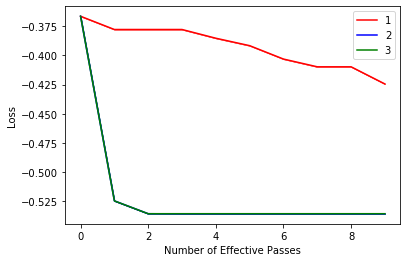

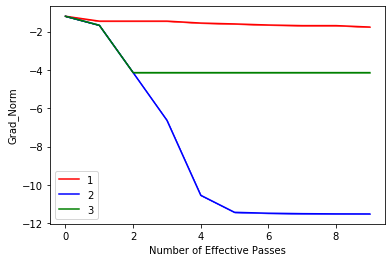

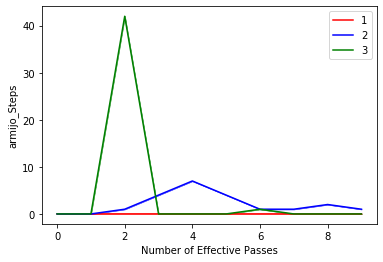

In [112]:
colors = ['r', 'b', 'g','r','b','g','r', 'b', 'g']
labels = ["1", "2", "3"]
fig = plot_shaded_error_bars(results_mean = results_mean, results_std = results_std, ylabel = 'Loss', max_epochs = max_epochs, colors = colors, labels = labels)
plt.show()

fig = plot_shaded_error_bars(results_mean = results2_mean, results_std = results2_std, ylabel = 'Grad_Norm', max_epochs = max_epochs, colors = colors, labels = labels)
plt.show()

#fig = plot_shaded_error_bars(results_mean = results3_mean, results_std = results3_std, ylabel = 'armijo_Steps', max_epochs = max_epochs, colors = colors, labels = labels)
#plt.show()

In [119]:
np.savetxt("./test", results_mean, delimiter= ",")